In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
%tensorflow_version 1.x
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


#data = pd.read_csv('/content/driver/My Drive/Colab Notebooks/data_science/AAPL.csv')
# ====== nhiệt độ LM35====
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LM35_TEST - Trang tính.csv')
# data_end = int(np.floor(0.8*(data.shape[0])))
# train = data[0:data_end]['Time']
# train =train.values.reshape(-1)
# test = data[data_end:]['Time'].values.reshape(-1)
# date_test = data[data_end:]['Date'].values.reshape(-1)
#============end LM35 =============
data['datetime']=data['Date'] + ' ' + data['Time'] # gộp 2 cột date và time
data.columns

Index(['Date', 'Time', 'TempC', 'Temp F', 'datetime'], dtype='object')

In [ ]:
data.head()

,Date,Time,TempC,Temp F,datetime
0,21/04/2021,08:10:20,28.80,83.85,21/04/2021 08:10:20
1,21/04/2021,08:15:23,28.80,83.85,21/04/2021 08:15:23
2,21/04/2021,08:20:26,28.80,83.85,21/04/2021 08:20:26
3,21/04/2021,08:25:28,27.02,80.64,21/04/2021 08:25:28
4,21/04/2021,08:30:31,28.80,83.85,21/04/2021 08:30:31


In [ ]:
data['datetime']=pd.to_datetime(data['datetime'])#chuyển cột ngày tháng thành kiểu datetime 
data.head()

,Date,Time,TempC,Temp F,datetime
0,21/04/2021,08:10:20,28.80,83.85,2021-04-21 08:10:20
1,21/04/2021,08:15:23,28.80,83.85,2021-04-21 08:15:23
2,21/04/2021,08:20:26,28.80,83.85,2021-04-21 08:20:26
3,21/04/2021,08:25:28,27.02,80.64,2021-04-21 08:25:28
4,21/04/2021,08:30:31,28.80,83.85,2021-04-21 08:30:31


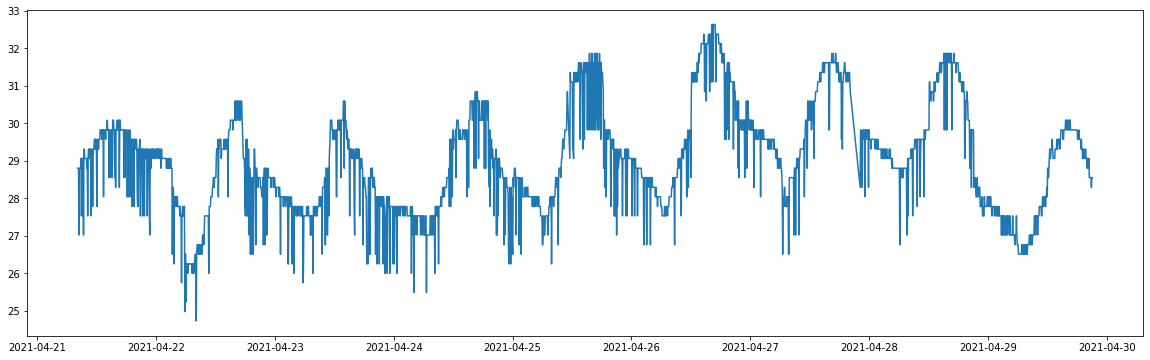

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(data['datetime'],data['TempC'].values)
plt.show()

In [ ]:
# Plot first 1000 values
plt.figure(figsize=(20,6))
plt.plot(data['datetime'].values[:100],data['TempC'].values[:100])
plt.show()

In [ ]:
from scipy.signal import savgol_filter
data['TempC'] = savgol_filter(data['TempC'],31, 3) # window size 51, polynomial order 3

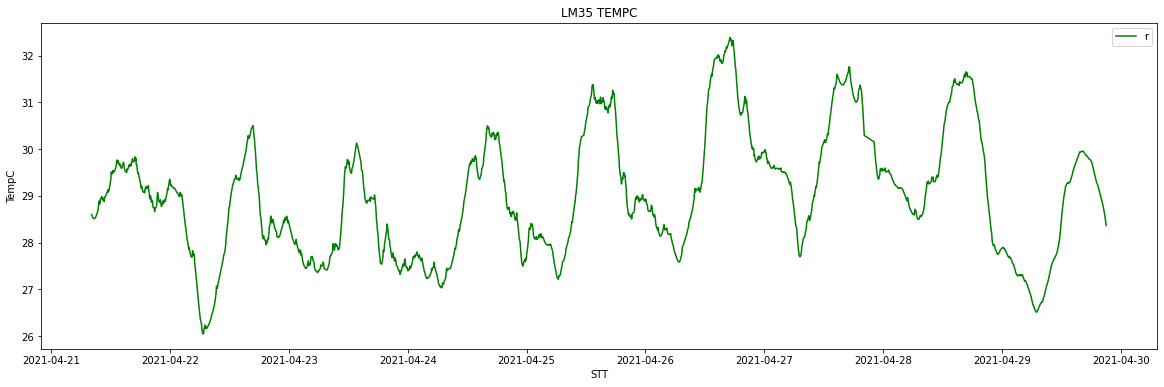

In [ ]:
plt.figure(figsize=(20,6))

plt.plot(data['datetime'],data['TempC'] ,color='g') #Vẽ kết quả thực tế
plt.title("LM35 TEMPC")
plt.xlabel("STT")
plt.ylabel("TempC")
plt.legend(('reality'),loc='upper right')
plt.show()

In [ ]:
## Normalize features  Chuẩn hóa dữ liệu , chuẩn hóa các đặc tính
dataTempC = data['TempC'] # gán cột Temc cho biến dataTempC 
dataTempC = dataTempC.values.reshape(-1,1) # đưa dataframe về dạng mảng ma trận nhiều chiều, rồi reshape về 1 cột và 2397 hàng 
scaler = MinMaxScaler(feature_range=(-1, 1)) # điều chỉnh dữ liệu để các đặc tính dữ liệu có có tỉ lệ [-1,1]
scaled = scaler.fit_transform(dataTempC) # thực hiện chuyển đổi
series = pd.DataFrame(scaled) # lưu dữ liệu vừa chuyển đổi vào biến series
print(series.head()) # in ra 5 hàng đầu tiên
print(series.shape) # in ra shape của series

          0
0 -0.194089
1 -0.203602
2 -0.211056
3 -0.216557
4 -0.220207
(2397, 1)


In [ ]:
# Setup the time steps , thiết lập bước thời gian
window_size = 50       # set window_size 
series_s = series.copy() # copy dữ liệu từ serie sang serie_s
for i in range(window_size): # vòng lặp for duyệt hết windown size 
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1) # trong vòng lặp for , serie được kết hợp serie và serie_s, lấy 50 giá trị để đoán giá trị thứ 51, axis=1
    
series.dropna(axis=0, inplace=True) # tạo index theo axis =0 , các cột có giá trị NaN sẽ drop
print(series.head()) # in 5 dòng đầu
print(series.shape) # in shape

          0         0         0  ...         0         0         0
0 -0.194089 -0.203602 -0.211056  ...  0.077255  0.083205  0.094164
1 -0.203602 -0.211056 -0.216557  ...  0.083205  0.094164  0.102255
2 -0.211056 -0.216557 -0.220207  ...  0.094164  0.102255  0.090798
3 -0.216557 -0.220207 -0.222111  ...  0.102255  0.090798  0.091005
4 -0.220207 -0.222111 -0.222372  ...  0.090798  0.091005  0.095001

[5 rows x 51 columns]
(2347, 51)


In [ ]:
#tiến hành chia dữ liệu thành 2 bộ, một bộ train chiếm 80% dữ liệu chính, và một bộ test chiếm 20% còn lại của dữ liệu.
# Split data into training (80%) and test (20%)
nrow = round(0.8*series.shape[0]) # lấy 80% dữ liệu từ series , lấy từ giá trị cột đầu tiên và hàng đầu tiên shape[0] 
train = series.iloc[:nrow, :] # dữ liệu train từ giá trị đầu đề giá trị cuối của nrow , tức là 80%
test = series.iloc[nrow:,:] # giá trị test từ giá trị tiếp sau nrow và đến hết tập dữ liệu của series, tức là 20%
print(train.shape) # in ra shape của test 
print(test.shape) # in ra shape của train

from sklearn.utils import shuffle # việc shuffle dữ liệu nhằm đảm bảo tính ngẫu nhiên của dữ liệu
train = shuffle(train) # shuffle tập train
# Discard the last value, bỏ giá trị cuối
train_X = train.iloc[:,:-1] # lấy đến cột kề cuối, đây là lable
train_y = train.iloc[:,-1] # lấy cột cuối cùng, đây là feature
test_X = test.iloc[:,:-1] # ta thực hiện tương tự vs test
test_y = test.iloc[:,-1]

train_X = train_X.values # ta lại tiến hành chuyển train và test về mảng nhiều chiều
print(train_X.shape)
train_y = train_y.values
print(train_y.shape)
test_X = test_X.values
print(test_X.shape)
test_y = test_y.values
print(test_y.shape)
date_test = data[1928:]['datetime'].values.reshape(-1) # date_test= số lượng dữ liệu test , lấy từ dòng 1928 của cột datatime để được 469 giá trị dateme để test
print(date_test.shape) # reshape(-1) đưa về biên dạng phù hợp với biên dạng ban đầu


(1878, 51)
(469, 51)
(1878, 50)
(1878,)
(469, 50)
(469,)
(469,)


In [ ]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)  #theo quy chuẩn của keras đầu vào của LSTM có dạng (batch_size, time_step, featủe)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
print(train_X.shape)
print(test_X.shape)

(1878, 50, 1)
(469, 50, 1)


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape=(50, 1), return_sequences=True, units=50))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('linear')) # linear
model.compile(loss="mse", optimizer="adam")
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params:

In [ ]:
t1 = datetime.datetime.now() # chuẩn hóa thời gian , time start
history = model.fit(train_X, train_y, batch_size=32, epochs=5, validation_split=0.1) # #https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
t2 = datetime.datetime.now() # time stop
print("Compilation Time : ", t2-t1)  # Compilation Time


Train on 1690 samples, validate on 188 samples
Epoch 1/5
1690/1690 [==============================] - 14s 8ms/step - loss: 0.0145 - val_loss: 0.0059
Epoch 2/5
1690/1690 [==============================] - 13s 8ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 3/5
1690/1690 [==============================] - 13s 7ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 4/5
1690/1690 [==============================] - 12s 7ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 5/5
1690/1690 [==============================] - 13s 7ms/step - loss: 0.0032 - val_loss: 0.0018
Compilation Time :  0:01:05.754835


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Baocao/100.h5')      

In [ ]:
# Doing a prediction on all the test data at once
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.models import load_model
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Baocao/100.h5')
preds = model.predict(test_X)
preds = scaler.inverse_transform(preds)# kết quả dự đoán 
print(preds.shape)
print(preds)

In [ ]:
test_y = test_y.reshape(-1, 1)
print(test_y.shape)
actuals = scaler.inverse_transform(test_y)# kết quả thực tế trong tập test_y
print(actuals)

In [ ]:
plt.figure(figsize=(20,6))
date_test = data[1928:]['datetime'].values.reshape(-1)
plt.plot(date_test,preds[:], color='r') #Vẽ kết quả dự đoán
plt.plot(date_test,actuals[:] ,color='g') #Vẽ kết quả thực tế
plt.title("Du doan TEMPC")
plt.xlabel("STT")
plt.ylabel("TempC")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(20,6))
saiso=preds[:]-actuals[:]
#saiso=saiso.mean()
date_test = data[1928:]['datetime'].values.reshape(-1)
plt.plot(saiso, color='b') #Vẽ kết quả dự đoán
plt.title(" sai so Du doan TEMPC")
plt.xlabel("STT")
plt.ylabel("TempC")

plt.show()

In [ ]:
rmse_error = mean_squared_error(actuals, preds)
print(rmse_error)

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()